In [1]:
%matplotlib inline
import torch
from torch import nn
from PIL import Image

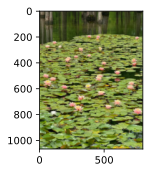

In [2]:
from d2l import torch as d2l
d2l.set_figsize()
content_img = d2l.Image.open('reality.jpeg')
d2l.plt.imshow(content_img);

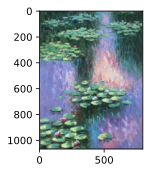

In [3]:
style_img = d2l.Image.open('waterlotus.jpeg')
d2l.plt.imshow(style_img);

In [4]:
from PIL import Image
import torchvision

rgb_mean = torch.tensor([0.485, 0.456, 0.406])
rgb_std = torch.tensor([0.229, 0.224, 0.225])

def preprocess(img, target_shape):
    # Calculate new shape while maintaining aspect ratio
    original_width, original_height = img.size
    target_width, target_height = target_shape
    aspect_ratio = original_width / original_height
    if target_width / target_height > aspect_ratio:
        target_width = int(target_height * aspect_ratio)
    else:
        target_height = int(target_width / aspect_ratio)
    
    # Resize image with new shape
    img = img.resize((target_width, target_height), Image.LANCZOS)
    
    # Apply transformations
    transforms = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(mean=rgb_mean, std=rgb_std)])
    return transforms(img).unsqueeze(0)

def postprocess(img):
    img = img[0].to(rgb_std.device)
    img = torch.clamp(img.permute(1, 2, 0) * rgb_std + rgb_mean, 0, 1)
    return torchvision.transforms.ToPILImage()(img.permute(2, 0, 1))

In [5]:
from torchvision.models.swin_transformer import swin_b, Swin_B_Weights

# 加载预训练的 Swin Transformer 模型
model = swin_b(weights = Swin_B_Weights.IMAGENET1K_V1)

#style_layers, content_layers = [0, 5, 10, 19, 28], [25]
content_layers = [7]          # 最后一个阶段的输出作为内容特征
style_layers = [2, 4, 6]   # 所有阶段的输出作为风格特征

In [6]:
#print(model)

In [7]:
# net = nn.Sequential(*[pretrained_net.features[i] for i in
#                    range(max(content_layers + style_layers) + 1)])

In [8]:
def extract_features_swin(X, content_layers, style_layers):
    features = []
    hooks = []

    def get_activation(name):
        def hook(model, input, output):
            features.append(output)
        return hook

    # Swin Transformer 的阶段在 model.features.layer 中
    for idx, layer in enumerate(model.features):
        hook = layer.register_forward_hook(get_activation(f'layer_{idx}'))
        hooks.append(hook)

    with torch.no_grad():
        model(X)

    for hook in hooks:
        hook.remove()

    # 打印收集的特征数量(debug)
    # print(f"Number of features collected: {len(features)}")

    # 确保索引在正确的范围内
    content_features = [features[i] for i in content_layers]
    style_features = [features[i] for i in style_layers]
    return content_features, style_features

# 获取内容和风格特征
def get_contents(image_shape, device):
    content_X = preprocess(content_img, image_shape).to(device)
    contents_Y, _ = extract_features_swin(content_X, content_layers, style_layers)
    return content_X, contents_Y

def get_styles(image_shape, device):
    style_X = preprocess(style_img, image_shape).to(device)
    _, styles_Y = extract_features_swin(style_X, content_layers, style_layers)
    return style_X, styles_Y

# 内容损失
def content_loss(Y_hat, Y):
    # 我们从动态计算梯度的树中分离目标：
    # 这是一个规定的值，而不是一个变量。
    return torch.square(Y_hat- Y.detach()).mean()

# 格拉姆矩阵
def gram(X):
    num_channels, n = X.shape[1], X.numel() // X.shape[1]
    X = X.reshape((num_channels, n))
    return torch.matmul(X, X.T) / (num_channels * n)

# 风格损失
def style_loss(Y_hat, gram_Y):
    return torch.square(gram(Y_hat)- gram_Y.detach()).mean()

# 全变分损失
def tv_loss(Y_hat):
    return 0.5 * (torch.abs(Y_hat[:, :, 1:, :]- Y_hat[:, :, :-1, :]).mean() +
                    torch.abs(Y_hat[:, :, :, 1:]- Y_hat[:, :, :, :-1]).mean())

In [9]:
content_weight, style_weight, tv_weight = 100, 1e5, 10
def compute_loss(X, contents_Y_hat, styles_Y_hat, contents_Y, styles_Y_gram):
    # 分别计算内容损失、风格损失和全变分损失
    contents_l = [content_loss(Y_hat, Y) * content_weight for Y_hat, Y in zip(
        contents_Y_hat, contents_Y)]
    styles_l = [style_loss(Y_hat, Y) * style_weight for Y_hat, Y in zip(
        styles_Y_hat, styles_Y_gram)]
    tv_l = tv_loss(X) * tv_weight
    # 对所有损失求和
    l = sum(10 * styles_l + contents_l + [tv_l])
    return contents_l, styles_l, tv_l, l

In [10]:
class SynthesizedImage(nn.Module):
    def __init__(self, img_shape, **kwargs):
        super(SynthesizedImage, self).__init__(**kwargs)
        self.weight = nn.Parameter(torch.rand(*img_shape))
    def forward(self):
        return self.weight
    
def get_inits(X, device, lr, styles_Y):
    gen_img = SynthesizedImage(X.shape).to(device)
    gen_img.weight.data.copy_(X.data)
    trainer = torch.optim.Adam(gen_img.parameters(), lr=lr)
    styles_Y_gram = [gram(Y) for Y in styles_Y]
    return gen_img(), styles_Y_gram, trainer

In [11]:
def train(X, contents_Y, styles_Y, device, lr, num_epochs, lr_decay_epoch):
    X, styles_Y_gram, trainer = get_inits(X, device, lr, styles_Y)
    scheduler = torch.optim.lr_scheduler.StepLR(trainer, lr_decay_epoch, 0.8)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                            xlim=[10, num_epochs],
                            legend=['content', 'style', 'TV'],
                            ncols=2, figsize=(7, 2.5))
    for epoch in range(num_epochs):
        trainer.zero_grad()
        contents_Y_hat, styles_Y_hat = extract_features_swin(
            X, content_layers, style_layers)
        contents_l, styles_l, tv_l, l = compute_loss(
            X, contents_Y_hat, styles_Y_hat, contents_Y, styles_Y_gram)
        l.backward()
        trainer.step()
        scheduler.step()
        if (epoch + 1) % 10 == 0:
            animator.axes[1].imshow(postprocess(X))
            animator.add(epoch + 1, [float(sum(contents_l)),
                                    float(sum(styles_l)), float(tv_l)])
    return X

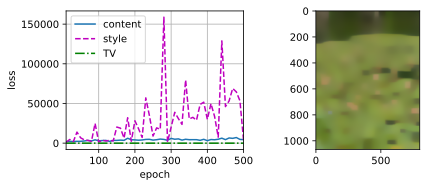

In [12]:
device, image_shape = d2l.try_gpu(), content_img.size
net = model.to(device)
content_X, contents_Y = get_contents(image_shape, device)
_, styles_Y = get_styles(image_shape, device)
output = train(content_X, contents_Y, styles_Y, device, 0.1, 500, 50)